# Proyecto Final: Modelo Predictivo de Burnout con Deep Neural Network


## 1. IMPORTACI√ìN DE DEPENDENCIAS

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc, mean_squared_error, r2_score, mean_absolute_error
)
from imblearn.over_sampling import SMOTE
from collections import Counter
import pickle
import warnings

# TensorFlow y Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, callbacks
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

warnings.filterwarnings('ignore')
tf.random.set_seed(42)
np.random.seed(42)

# Configuraciones
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)

print(f"GPU disponible: {len(tf.config.list_physical_devices('GPU')) > 0}")

GPU disponible: True


## 2. CARGA Y PREPROCESAMIENTO DEL DATASET

In [21]:
try:
    dataset = pd.read_csv('Proyecto_final.csv', sep=';')
    print(f"\n‚úì Dataset cargado: {dataset.shape[0]} filas x {dataset.shape[1]} columnas")
except FileNotFoundError:
    print("Error: El archivo 'Proyecto_final.csv' no se encontr√≥.")
    raise

# Informaci√≥n b√°sica
print(f"\n{'='*80}")
print("INFORMACI√ìN DEL DATASET")
print(f"{'='*80}")
dataset.info()


‚úì Dataset cargado: 103 filas x 145 columnas

INFORMACI√ìN DEL DATASET
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Columns: 145 entries, Id to GBC_Puntaje
dtypes: float64(4), int64(136), object(5)
memory usage: 116.8+ KB


In [22]:
# Eliminar columnas innecesarias
columns_to_drop = [
    'GBC_Puntaje', 'LGS_Puntaje', 'PERMA_Puntaje', 'Id', 'Formulario', 
    'Horadeinicio', 'Horadefinalizaci√É¬≥n', 'HoraRealizacion', 'TiempoRequerido', 'CI',
    'Diplomatura', 'Maestria', 'Doctorado', 'AE_MBI', 'Nivel_AE_MBI', 
    'RP_MBI', 'Nivel_RP_MBI', 'DSP_MBI', 'Nivel_DSP_MBI'
]
dataset_cleaned = dataset.drop(columns=[col for col in columns_to_drop if col in dataset.columns])

# Tratamiento de valores especiales y nulos
dataset_cleaned = dataset_cleaned.replace(999, np.nan)
null_counts = dataset_cleaned.isnull().sum(axis=1)
rows_to_drop = null_counts[null_counts > dataset_cleaned.shape[1] * 0.5].index
dataset_cleaned = dataset_cleaned.drop(rows_to_drop)

# Imputaci√≥n de nulos con mediana
numeric_cols = dataset_cleaned.select_dtypes(include=np.number).columns
for col in numeric_cols:
    if dataset_cleaned[col].isnull().sum() > 0:
        dataset_cleaned[col].fillna(dataset_cleaned[col].median(), inplace=True)

# Conversi√≥n de variables discretas a categ√≥ricas
categorical_threshold = 20
for col in dataset_cleaned.select_dtypes(include=['number']).columns:
    if dataset_cleaned[col].nunique() < categorical_threshold:
        dataset_cleaned[col] = dataset_cleaned[col].astype('category')

# Asegurar que Jerarquia sea num√©rica
if 'Jerarquia' in dataset_cleaned.columns:
    dataset_cleaned['Jerarquia'] = pd.to_numeric(dataset_cleaned['Jerarquia'], errors='coerce')
    if dataset_cleaned['Jerarquia'].isnull().sum() > 0:
        dataset_cleaned['Jerarquia'].fillna(dataset_cleaned['Jerarquia'].median(), inplace=True)
    dataset_cleaned['Jerarquia'] = dataset_cleaned['Jerarquia'].astype('category')

# Transformaci√≥n logar√≠tmica para asimetr√≠a
numeric_cols = dataset_cleaned.select_dtypes(include=[np.number]).columns
skewness_df = dataset_cleaned[numeric_cols].skew().sort_values(ascending=False)
skewed_cols = skewness_df[skewness_df > 1].index.tolist()
skewed_cols = [col for col in skewed_cols if col not in ['MBI_Burnout', 'MBI_RiesgoBurnout1']]

for col in skewed_cols:
    dataset_cleaned[f'{col}_log'] = np.log1p(dataset_cleaned[col])
    dataset_cleaned = dataset_cleaned.drop(col, axis=1)

print(f"‚úì Preprocesamiento completado: {dataset_cleaned.shape}")

‚úì Preprocesamiento completado: (102, 127)


## 3. PREPARACI√ìN DE DATOS

In [23]:
target_cols = ['MBI_Burnout', 'MBI_RiesgoBurnout1']

# Clasificaci√≥n
y_classification = dataset_cleaned['MBI_Burnout'].copy().values
X = dataset_cleaned.drop(columns=target_cols)

# Regresi√≥n
y_regression = dataset_cleaned['MBI_RiesgoBurnout1'].copy().values

# Codificaci√≥n One-Hot
X_encoded = pd.get_dummies(X, drop_first=True)
feature_names = X_encoded.columns.tolist()

print(f"\n‚úì Features despu√©s de encoding: {X_encoded.shape}")
print(f"‚úì Distribuci√≥n de clases: {Counter(y_classification)}")


‚úì Features despu√©s de encoding: (102, 628)
‚úì Distribuci√≥n de clases: Counter({0.0: 82, 1.0: 20})


## 4. ARQUITECTURA DE LA RED NEURONAL

In [24]:
def create_classification_model(input_dim, learning_rate=0.001):
    """
    DNN para clasificaci√≥n binaria optimizada para datasets peque√±os
    """
    model = Sequential([
        Input(shape=(input_dim,)),
        
        # Primera capa: m√°s neuronas para capturar patrones
        Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.4),
        
        # Segunda capa
        Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.3),
        
        # Tercera capa
        Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.3),
        
        # Cuarta capa
        Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.2),
        
        # Capa de salida
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc'), 
                 tf.keras.metrics.Precision(name='precision'),
                 tf.keras.metrics.Recall(name='recall')]
    )
    
    return model

In [25]:
def create_regression_model(input_dim, learning_rate=0.001):
    """
    DNN para regresi√≥n optimizada para datasets peque√±os
    """
    model = Sequential([
        Input(shape=(input_dim,)),
        
        Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.4),
        
        Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.2),
        
        Dense(1, activation='linear')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='mse',
        metrics=['mae', 'mse', tf.keras.metrics.RootMeanSquaredError(name='rmse')]
    )
    
    return model

## 5. K-FOLD CROSS VALIDATION - CLASIFICACI√ìN

In [26]:
print(f"\n{'='*80}")
print("ENTRENAMIENTO CON K-FOLD CROSS VALIDATION - CLASIFICACI√ìN")
print(f"{'='*80}")

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# M√©tricas por fold
fold_metrics_clf = {
    'accuracy': [], 'precision': [], 'recall': [], 
    'f1': [], 'auc': [], 'loss': []
}

# Historiales de entrenamiento
fold_histories_clf = []

# Modelos entrenados
trained_models_clf = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_encoded, y_classification), 1):
    print(f"\n{'-'*80}")
    print(f"FOLD {fold}/{n_splits}")
    print(f"{'-'*78}")
    
    # Split de datos
    X_train_fold = X_encoded.iloc[train_idx].values
    y_train_fold = y_classification[train_idx]
    X_val_fold = X_encoded.iloc[val_idx].values
    y_val_fold = y_classification[val_idx]
    
    print(f"Train: {len(train_idx)} | Val: {len(val_idx)}")
    print(f"Distribuci√≥n train: {Counter(y_train_fold)}")
    
    # Aplicar SMOTE solo en train
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_fold, y_train_fold)
    print(f"Despu√©s de SMOTE: {Counter(y_train_resampled)}")
    
    # Escalar
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_resampled)
    X_val_scaled = scaler.transform(X_val_fold)
    
    # Crear y entrenar modelo
    model = create_classification_model(X_train_scaled.shape[1])
    
    # Callbacks
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
        verbose=0
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-6,
        verbose=0
    )
    
    # Entrenar
    history = model.fit(
        X_train_scaled, y_train_resampled,
        validation_data=(X_val_scaled, y_val_fold),
        epochs=400,
        batch_size=16,
        callbacks=[early_stop, reduce_lr],
        verbose=0
    )
    
    fold_histories_clf.append(history)
    
    # Evaluar
    y_pred_proba = model.predict(X_val_scaled, verbose=0).flatten()
    y_pred = (y_pred_proba > 0.5).astype(int)
    
    # Calcular m√©tricas
    acc = accuracy_score(y_val_fold, y_pred)
    prec = precision_score(y_val_fold, y_pred, zero_division=0)
    rec = recall_score(y_val_fold, y_pred, zero_division=0)
    f1 = f1_score(y_val_fold, y_pred, zero_division=0)
    auc_score = roc_auc_score(y_val_fold, y_pred_proba)
    val_loss = history.history['val_loss'][-1]
    
    fold_metrics_clf['accuracy'].append(acc)
    fold_metrics_clf['precision'].append(prec)
    fold_metrics_clf['recall'].append(rec)
    fold_metrics_clf['f1'].append(f1)
    fold_metrics_clf['auc'].append(auc_score)
    fold_metrics_clf['loss'].append(val_loss)
    
    print(f"\n‚úì Accuracy: {acc:.4f}")
    print(f"‚úì Precision: {prec:.4f}")
    print(f"‚úì Recall: {rec:.4f}")
    print(f"‚úì F1-Score: {f1:.4f}")
    print(f"‚úì AUC-ROC: {auc_score:.4f}")
    print(f"‚úì Val Loss: {val_loss:.4f}")
    print(f"‚úì Epochs entrenadas: {len(history.history['loss'])}")
    
    trained_models_clf.append({
        'model': model,
        'scaler': scaler,
        'metrics': {
            'accuracy': acc, 'precision': prec, 'recall': rec,
            'f1': f1, 'auc': auc_score
        }
    })


ENTRENAMIENTO CON K-FOLD CROSS VALIDATION - CLASIFICACI√ìN

--------------------------------------------------------------------------------
FOLD 1/5
------------------------------------------------------------------------------


Train: 81 | Val: 21
Distribuci√≥n train: Counter({0.0: 65, 1.0: 16})
Despu√©s de SMOTE: Counter({np.float64(0.0): 65, np.float64(1.0): 65})

‚úì Accuracy: 0.9048
‚úì Precision: 0.6667
‚úì Recall: 1.0000
‚úì F1-Score: 0.8000
‚úì AUC-ROC: 0.9706
‚úì Val Loss: 0.6723
‚úì Epochs entrenadas: 109

--------------------------------------------------------------------------------
FOLD 2/5
------------------------------------------------------------------------------
Train: 81 | Val: 21
Distribuci√≥n train: Counter({0.0: 65, 1.0: 16})
Despu√©s de SMOTE: Counter({np.float64(0.0): 65, np.float64(1.0): 65})

‚úì Accuracy: 0.8571
‚úì Precision: 1.0000
‚úì Recall: 0.2500
‚úì F1-Score: 0.4000
‚úì AUC-ROC: 0.7647
‚úì Val Loss: 1.0487
‚úì Epochs entrenadas: 54

--------------------------------------------------------------------------------
FOLD 3/5
------------------------------------------------------------------------------
Train: 82 | Val: 20
Distribuci√≥n train: Counter({0.0: 66, 1.0: 16})
Despu√©s

In [27]:
# Resumen de resultados
print(f"\n{'='*80}")
print("RESULTADOS PROMEDIO K-FOLD CROSS VALIDATION - CLASIFICACI√ìN")
print(f"{'='*80}")

for metric_name, values in fold_metrics_clf.items():
    mean_val = np.mean(values)
    std_val = np.std(values)
    print(f"{metric_name.upper():.<20} {mean_val:.4f} ¬± {std_val:.4f}")

# Seleccionar mejor modelo (por F1-Score)
best_fold_idx = np.argmax(fold_metrics_clf['f1'])
best_model_clf = trained_models_clf[best_fold_idx]
print(f"\n‚úì Mejor modelo: Fold {best_fold_idx + 1} (F1={fold_metrics_clf['f1'][best_fold_idx]:.4f})")


RESULTADOS PROMEDIO K-FOLD CROSS VALIDATION - CLASIFICACI√ìN
ACCURACY............ 0.8324 ¬± 0.0762
PRECISION........... 0.5833 ¬± 0.4014
RECALL.............. 0.4000 ¬± 0.3391
F1.................. 0.4233 ¬± 0.2867
AUC................. 0.7533 ¬± 0.1962
LOSS................ 0.9775 ¬± 0.2083

‚úì Mejor modelo: Fold 1 (F1=0.8000)


## 6. K-FOLD CROSS VALIDATION - REGRESI√ìN

In [28]:
print(f"\n{'='*80}")
print("ENTRENAMIENTO CON K-FOLD CROSS VALIDATION - REGRESI√ìN")
print(f"{'='*80}")

kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

fold_metrics_reg = {
    'r2': [], 'mae': [], 'rmse': [], 'mse': []
}

fold_histories_reg = []
trained_models_reg = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_encoded), 1):
    print(f"\n{'-'*80}")
    print(f"FOLD {fold}/{n_splits}")
    print(f"{'-'*78}")
    
    X_train_fold = X_encoded.iloc[train_idx].values
    y_train_fold = y_regression[train_idx]
    X_val_fold = X_encoded.iloc[val_idx].values
    y_val_fold = y_regression[val_idx]
    
    print(f"Train: {len(train_idx)} | Val: {len(val_idx)}")
    
    # Escalar
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_fold)
    X_val_scaled = scaler.transform(X_val_fold)
    
    # Crear modelo
    model = create_regression_model(X_train_scaled.shape[1])
    
    # Callbacks
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
        verbose=0
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-6,
        verbose=0
    )
    
    # Entrenar
    history = model.fit(
        X_train_scaled, y_train_fold,
        validation_data=(X_val_scaled, y_val_fold),
        epochs=400,
        batch_size=16,
        callbacks=[early_stop, reduce_lr],
        verbose=0
    )
    
    fold_histories_reg.append(history)
    
    # Evaluar
    y_pred = model.predict(X_val_scaled, verbose=0).flatten()
    
    r2 = r2_score(y_val_fold, y_pred)
    mae = mean_absolute_error(y_val_fold, y_pred)
    mse = mean_squared_error(y_val_fold, y_pred)
    rmse = np.sqrt(mse)
    
    fold_metrics_reg['r2'].append(r2)
    fold_metrics_reg['mae'].append(mae)
    fold_metrics_reg['rmse'].append(rmse)
    fold_metrics_reg['mse'].append(mse)
    
    print(f"\n‚úì R¬≤ Score: {r2:.4f}")
    print(f"‚úì MAE: {mae:.4f}")
    print(f"‚úì RMSE: {rmse:.4f}")
    print(f"‚úì MSE: {mse:.4f}")
    print(f"‚úì Epochs entrenadas: {len(history.history['loss'])}")
    
    trained_models_reg.append({
        'model': model,
        'scaler': scaler,
        'metrics': {'r2': r2, 'mae': mae, 'rmse': rmse}
    })


ENTRENAMIENTO CON K-FOLD CROSS VALIDATION - REGRESI√ìN

--------------------------------------------------------------------------------
FOLD 1/5
------------------------------------------------------------------------------
Train: 81 | Val: 21

‚úì R¬≤ Score: 0.3337
‚úì MAE: 0.2858
‚úì RMSE: 0.3477
‚úì MSE: 0.1209
‚úì Epochs entrenadas: 81

--------------------------------------------------------------------------------
FOLD 2/5
------------------------------------------------------------------------------
Train: 81 | Val: 21

‚úì R¬≤ Score: -0.4481
‚úì MAE: 0.4883
‚úì RMSE: 0.5436
‚úì MSE: 0.2955
‚úì Epochs entrenadas: 31

--------------------------------------------------------------------------------
FOLD 3/5
------------------------------------------------------------------------------
Train: 82 | Val: 20

‚úì R¬≤ Score: 0.1061
‚úì MAE: 0.3371
‚úì RMSE: 0.4094
‚úì MSE: 0.1676
‚úì Epochs entrenadas: 34

------------------------------------------------------------------------------

In [29]:
# Resumen regresi√≥n
print(f"\n{'='*80}")
print("RESULTADOS PROMEDIO K-FOLD CROSS VALIDATION - REGRESI√ìN")
print(f"{'='*80}")

for metric_name, values in fold_metrics_reg.items():
    mean_val = np.mean(values)
    std_val = np.std(values)
    print(f"{metric_name.upper():.<20} {mean_val:.4f} ¬± {std_val:.4f}")

best_fold_idx_reg = np.argmax(fold_metrics_reg['r2'])
best_model_reg = trained_models_reg[best_fold_idx_reg]
print(f"\n‚úì Mejor modelo: Fold {best_fold_idx_reg + 1} (R¬≤={fold_metrics_reg['r2'][best_fold_idx_reg]:.4f})")


RESULTADOS PROMEDIO K-FOLD CROSS VALIDATION - REGRESI√ìN
R2.................. -0.0083 ¬± 0.2870
MAE................. 0.3617 ¬± 0.0794
RMSE................ 0.4335 ¬± 0.0788
MSE................. 0.1941 ¬± 0.0702

‚úì Mejor modelo: Fold 1 (R¬≤=0.3337)


## 7. VISUALIZACIONES

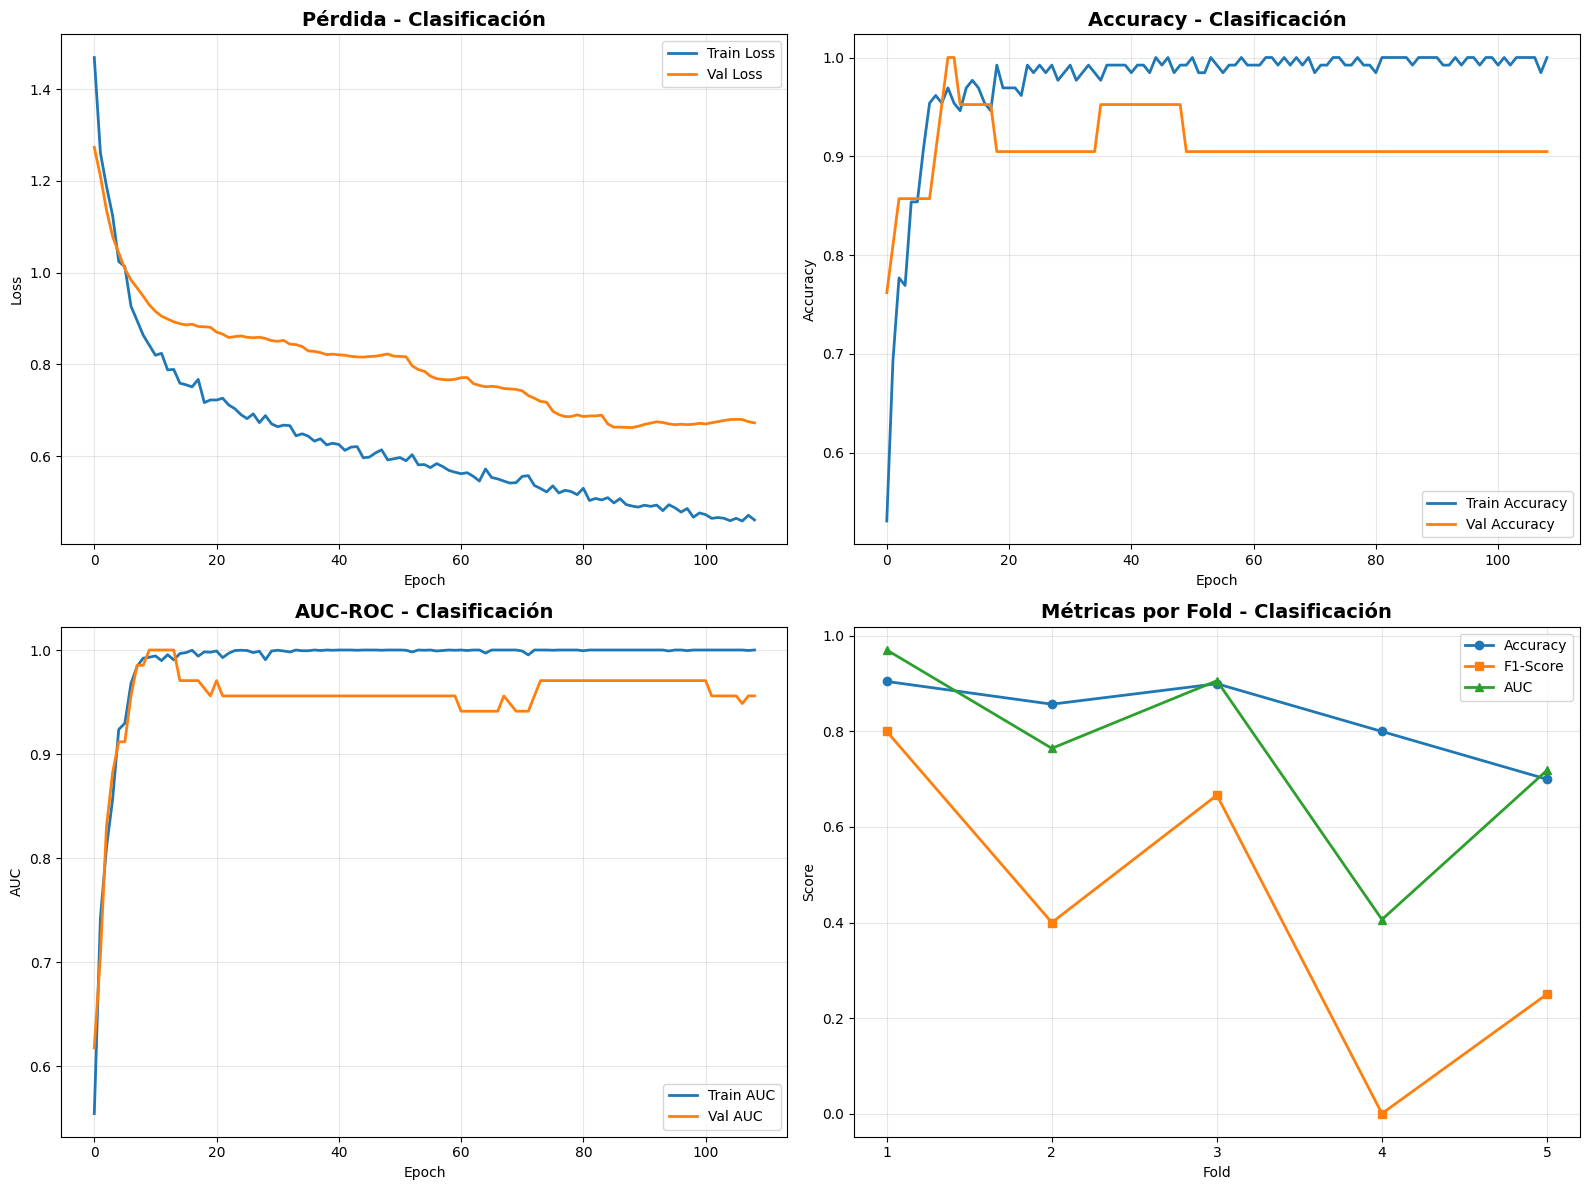

In [30]:
# Historia de entrenamiento del mejor modelo de clasificaci√≥n
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

best_history_clf = fold_histories_clf[best_fold_idx]

# Loss
axes[0, 0].plot(best_history_clf.history['loss'], label='Train Loss', linewidth=2)
axes[0, 0].plot(best_history_clf.history['val_loss'], label='Val Loss', linewidth=2)
axes[0, 0].set_title('P√©rdida - Clasificaci√≥n', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Accuracy
axes[0, 1].plot(best_history_clf.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0, 1].plot(best_history_clf.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[0, 1].set_title('Accuracy - Clasificaci√≥n', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# AUC
axes[1, 0].plot(best_history_clf.history['auc'], label='Train AUC', linewidth=2)
axes[1, 0].plot(best_history_clf.history['val_auc'], label='Val AUC', linewidth=2)
axes[1, 0].set_title('AUC-ROC - Clasificaci√≥n', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('AUC')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# M√©tricas por fold
fold_numbers = list(range(1, n_splits + 1))
axes[1, 1].plot(fold_numbers, fold_metrics_clf['accuracy'], marker='o', label='Accuracy', linewidth=2)
axes[1, 1].plot(fold_numbers, fold_metrics_clf['f1'], marker='s', label='F1-Score', linewidth=2)
axes[1, 1].plot(fold_numbers, fold_metrics_clf['auc'], marker='^', label='AUC', linewidth=2)
axes[1, 1].set_title('M√©tricas por Fold - Clasificaci√≥n', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Fold')
axes[1, 1].set_ylabel('Score')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)
axes[1, 1].set_xticks(fold_numbers)

plt.tight_layout()
plt.show()

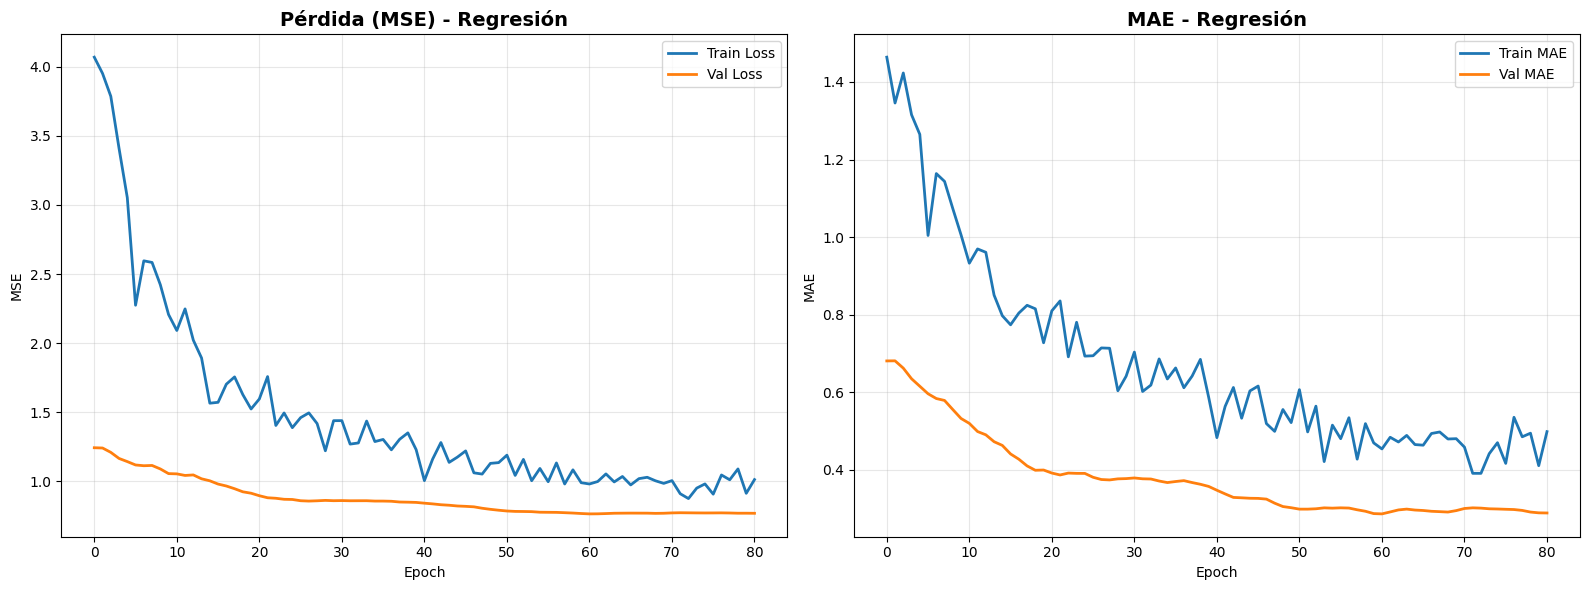

In [31]:
# Historia de regresi√≥n
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

best_history_reg = fold_histories_reg[best_fold_idx_reg]

# Loss
axes[0].plot(best_history_reg.history['loss'], label='Train Loss', linewidth=2)
axes[0].plot(best_history_reg.history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_title('P√©rdida (MSE) - Regresi√≥n', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MSE')
axes[0].legend()
axes[0].grid(alpha=0.3)

# MAE
axes[1].plot(best_history_reg.history['mae'], label='Train MAE', linewidth=2)
axes[1].plot(best_history_reg.history['val_mae'], label='Val MAE', linewidth=2)
axes[1].set_title('MAE - Regresi√≥n', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 8. EVALUACI√ìN EN TEST SET HOLDOUT (20%)

In [32]:
print(f"\n{'='*80}")
print("EVALUACI√ìN FINAL EN TEST SET HOLDOUT")
print(f"{'='*80}")

# Separar test set (20% del dataset completo)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_encoded, y_classification, test_size=0.2, random_state=42, stratify=y_classification
)

X_train_reg_full, X_test_reg, y_train_reg_full, y_test_reg = train_test_split(
    X_encoded, y_regression, test_size=0.2, random_state=42
)

print(f"\nTest set: {len(X_test)} samples")
print(f"Distribuci√≥n test: {Counter(y_test)}")


EVALUACI√ìN FINAL EN TEST SET HOLDOUT

Test set: 21 samples
Distribuci√≥n test: Counter({0.0: 17, 1.0: 4})


In [33]:
# Evaluar clasificaci√≥n
scaler_clf_final = best_model_clf['scaler']
X_test_scaled = scaler_clf_final.transform(X_test)

y_test_pred_proba = best_model_clf['model'].predict(X_test_scaled, verbose=0).flatten()
y_test_pred = (y_test_pred_proba > 0.5).astype(int)

print(f"\n{'-'*80}")
print("CLASIFICACI√ìN - RESULTADOS EN TEST SET")
print(f"{'-'*78}")

acc_test = accuracy_score(y_test, y_test_pred)
prec_test = precision_score(y_test, y_test_pred, zero_division=0)
rec_test = recall_score(y_test, y_test_pred, zero_division=0)
f1_test = f1_score(y_test, y_test_pred, zero_division=0)
auc_test = roc_auc_score(y_test, y_test_pred_proba)

print(f"\n‚úì Accuracy: {acc_test:.4f}")
print(f"‚úì Precision: {prec_test:.4f}")
print(f"‚úì Recall: {rec_test:.4f}")
print(f"‚úì F1-Score: {f1_test:.4f}")
print(f"‚úì AUC-ROC: {auc_test:.4f}")

print(f"\n{classification_report(y_test, y_test_pred, target_names=['No Burnout', 'Burnout'])}")


--------------------------------------------------------------------------------
CLASIFICACI√ìN - RESULTADOS EN TEST SET
------------------------------------------------------------------------------

‚úì Accuracy: 1.0000
‚úì Precision: 1.0000
‚úì Recall: 1.0000
‚úì F1-Score: 1.0000
‚úì AUC-ROC: 1.0000

              precision    recall  f1-score   support

  No Burnout       1.00      1.00      1.00        17
     Burnout       1.00      1.00      1.00         4

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21



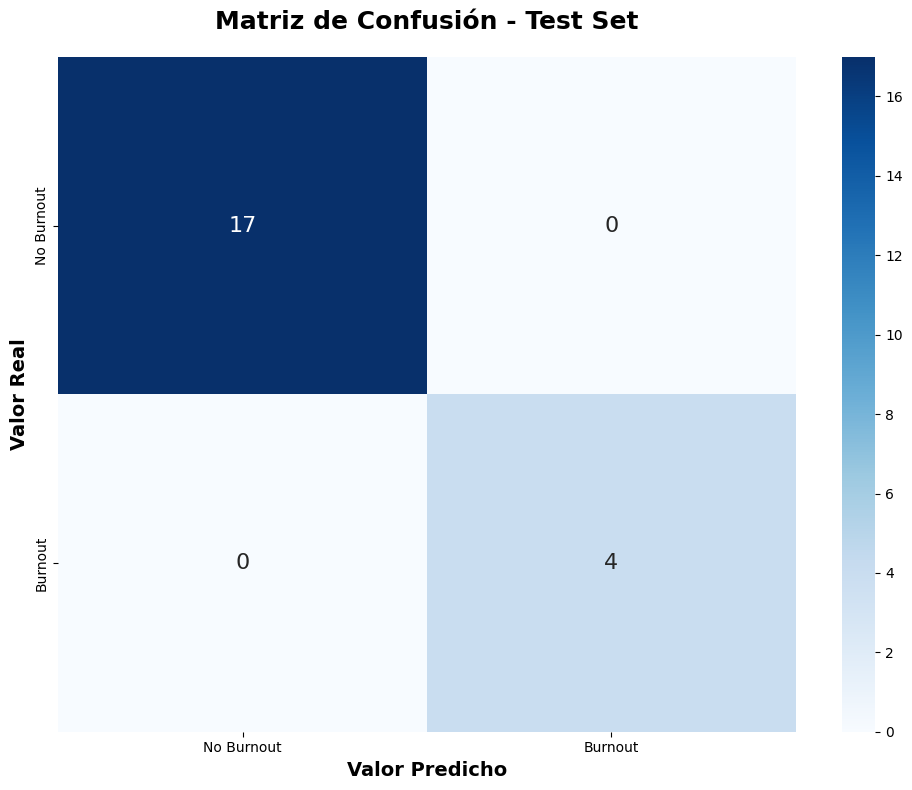

In [34]:
# Matriz de confusi√≥n
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['No Burnout', 'Burnout'], 
            yticklabels=['No Burnout', 'Burnout'],
            annot_kws={'size': 16})
plt.title('Matriz de Confusi√≥n - Test Set', fontsize=18, fontweight='bold', pad=20)
plt.ylabel('Valor Real', fontsize=14, fontweight='bold')
plt.xlabel('Valor Predicho', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [35]:
# Evaluar regresi√≥n
scaler_reg_final = best_model_reg['scaler']
X_test_reg_scaled = scaler_reg_final.transform(X_test_reg)

y_test_reg_pred = best_model_reg['model'].predict(X_test_reg_scaled, verbose=0).flatten()

print(f"\n{'-'*80}")
print("REGRESI√ìN - RESULTADOS EN TEST SET")
print(f"{'-'*78}")

r2_test = r2_score(y_test_reg, y_test_reg_pred)
mae_test = mean_absolute_error(y_test_reg, y_test_reg_pred)
rmse_test = np.sqrt(mean_squared_error(y_test_reg, y_test_reg_pred))

print(f"\n‚úì R¬≤ Score: {r2_test:.4f}")
print(f"‚úì MAE: {mae_test:.4f}")
print(f"‚úì RMSE: {rmse_test:.4f}")


--------------------------------------------------------------------------------
REGRESI√ìN - RESULTADOS EN TEST SET
------------------------------------------------------------------------------

‚úì R¬≤ Score: 0.3337
‚úì MAE: 0.2858
‚úì RMSE: 0.3477


TypeError: Categorical is not ordered for operation min
you can use .as_ordered() to change the Categorical to an ordered one


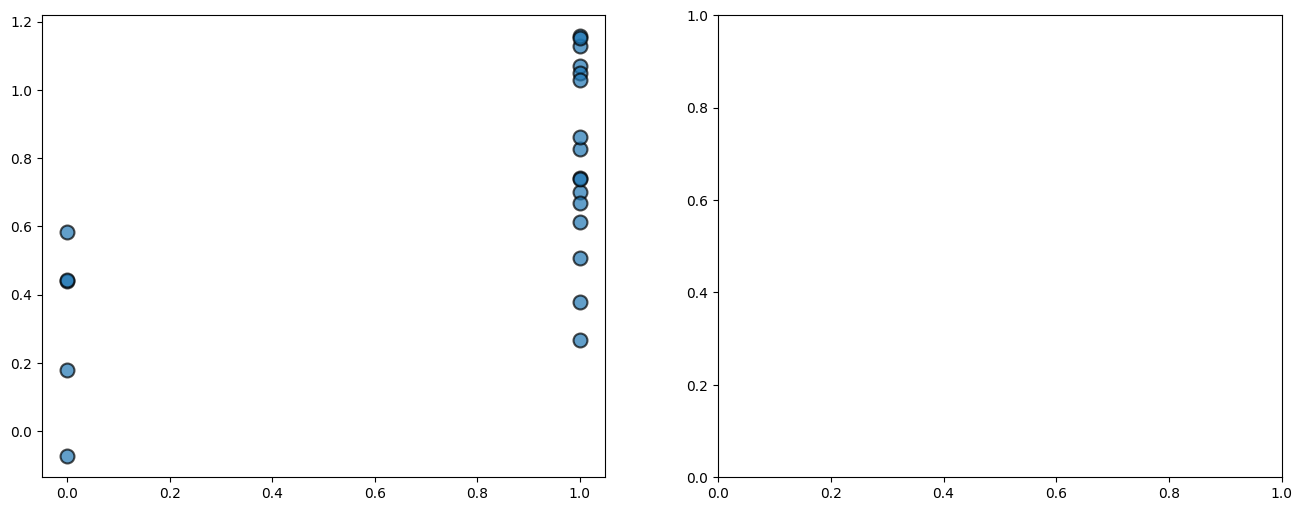

In [36]:
# Visualizaci√≥n regresi√≥n
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].scatter(y_test_reg, y_test_reg_pred, alpha=0.7, s=100, edgecolors='k', linewidth=1.5)
min_val = min(y_test_reg.min(), y_test_reg_pred.min())
max_val = max(y_test_reg.max(), y_test_reg_pred.max())
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Predicci√≥n Perfecta')
axes[0].set_xlabel('Valores Reales', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Valores Predichos', fontsize=12, fontweight='bold')
axes[0].set_title(f'Valores Reales vs Predichos (R¬≤={r2_test:.3f})', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

residuals = y_test_reg - y_test_reg_pred
axes[1].scatter(y_test_reg_pred, residuals, alpha=0.7, s=100, edgecolors='k', linewidth=1.5)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2, label='Residuo = 0')
axes[1].set_xlabel('Valores Predichos', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Residuos', fontsize=12, fontweight='bold')
axes[1].set_title('Gr√°fico de Residuos', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. GUARDAR MODELOS Y ARTEFACTOS

In [ ]:
artifacts = {
    'classification_model': best_model_clf['model'],
    'regression_model': best_model_reg['model'],
    'classification_scaler': best_model_clf['scaler'],
    'regression_scaler': best_model_reg['scaler'],
    'feature_columns': feature_names,
    'fold_metrics_clf': fold_metrics_clf,
    'fold_metrics_reg': fold_metrics_reg,
    'test_metrics_clf': {
        'accuracy': acc_test,
        'precision': prec_test,
        'recall': rec_test,
        'f1': f1_test,
        'auc': auc_test
    },
    'test_metrics_reg': {
        'r2': r2_test,
        'mae': mae_test,
        'rmse': rmse_test
    }
}

# Guardar modelos en formato nativo de Keras
best_model_clf['model'].save('classification_model.h5')
best_model_reg['model'].save('regression_model.h5')
print("\n‚úì Modelos guardados en formato .h5")

# Guardar artefactos (scalers y metadata)
with open('dnn_model_artifacts.pkl', 'wb') as f:
    pickle.dump({
        'classification_scaler': best_model_clf['scaler'],
        'regression_scaler': best_model_reg['scaler'],
        'feature_columns': feature_names,
        'fold_metrics_clf': fold_metrics_clf,
        'fold_metrics_reg': fold_metrics_reg,
        'test_metrics_clf': artifacts['test_metrics_clf'],
        'test_metrics_reg': artifacts['test_metrics_reg']
    }, f)

print("‚úì Artefactos guardados en 'dnn_model_artifacts.pkl'")

## 10. RESUMEN COMPARATIVO: CV vs TEST

In [ ]:
print(f"\n{'='*80}")
print("RESUMEN COMPARATIVO: K-FOLD CV vs TEST SET")
print(f"{'='*80}")

print("\nüìä CLASIFICACI√ìN:")
print(f"{'M√©trica':<15} {'CV Mean':<15} {'CV Std':<15} {'Test':<15} {'Diferencia':<15}")
print("-" * 75)

metrics_to_compare_clf = ['accuracy', 'precision', 'recall', 'f1', 'auc']
test_values_clf = [acc_test, prec_test, rec_test, f1_test, auc_test]

for metric, test_val in zip(metrics_to_compare_clf, test_values_clf):
    cv_mean = np.mean(fold_metrics_clf[metric])
    cv_std = np.std(fold_metrics_clf[metric])
    diff = test_val - cv_mean
    print(f"{metric.upper():<15} {cv_mean:<15.4f} {cv_std:<15.4f} {test_val:<15.4f} {diff:+.4f}")

print("\nüìà REGRESI√ìN:")
print(f"{'M√©trica':<15} {'CV Mean':<15} {'CV Std':<15} {'Test':<15} {'Diferencia':<15}")
print("-" * 75)

metrics_to_compare_reg = ['r2', 'mae', 'rmse']
test_values_reg = [r2_test, mae_test, rmse_test]

for metric, test_val in zip(metrics_to_compare_reg, test_values_reg):
    cv_mean = np.mean(fold_metrics_reg[metric])
    cv_std = np.std(fold_metrics_reg[metric])
    diff = test_val - cv_mean
    print(f"{metric.upper():<15} {cv_mean:<15.4f} {cv_std:<15.4f} {test_val:<15.4f} {diff:+.4f}")

## 11. FUNCI√ìN DE PREDICCI√ìN PARA NUEVOS DATOS

In [ ]:
def predict_burnout(new_data_df, model_type='classification'):
    """
    Funci√≥n para predecir burnout en nuevos datos
    
    Parameters:
    -----------
    new_data_df : pandas DataFrame
        DataFrame con las mismas columnas que el dataset original (sin targets)
    model_type : str
        'classification' o 'regression'
    
    Returns:
    --------
    predictions : numpy array
        Predicciones del modelo
    probabilities : numpy array (solo para clasificaci√≥n)
        Probabilidades de pertenencia a cada clase
    """
    
    # Preprocesar igual que los datos de entrenamiento
    # (aplicar mismas transformaciones, encoding, etc.)
    
    if model_type == 'classification':
        model = best_model_clf['model']
        scaler = best_model_clf['scaler']
        
        # Asegurar que tenga las mismas columnas
        for col in feature_names:
            if col not in new_data_df.columns:
                new_data_df[col] = 0
        
        new_data_df = new_data_df[feature_names]
        
        # Escalar
        new_data_scaled = scaler.transform(new_data_df)
        
        # Predecir
        probabilities = model.predict(new_data_scaled, verbose=0).flatten()
        predictions = (probabilities > 0.5).astype(int)
        
        return predictions, probabilities
    
    elif model_type == 'regression':
        model = best_model_reg['model']
        scaler = best_model_reg['scaler']
        
        # Asegurar columnas
        for col in feature_names:
            if col not in new_data_df.columns:
                new_data_df[col] = 0
        
        new_data_df = new_data_df[feature_names]
        
        # Escalar
        new_data_scaled = scaler.transform(new_data_df)
        
        # Predecir
        predictions = model.predict(new_data_scaled, verbose=0).flatten()
        
        return predictions

In [ ]:
print(f"\n{'='*80}")
print("PROCESO COMPLETADO")
print(f"{'='*80}")
print("\n‚úì Modelos DNN entrenados con K-Fold Cross Validation")
print("‚úì Evaluaci√≥n en test set completada")
print("‚úì Artefactos guardados correctamente")
print("\nArchivos generados:")
print("  - classification_model.h5")
print("  - regression_model.h5")
print("  - dnn_model_artifacts.pkl")
print("\nüìå Usa la funci√≥n predict_burnout() para hacer predicciones en nuevos datos")

## 12. EJEMPLO DE USO

In [ ]:
print(f"\n{'='*80}")
print("EJEMPLO DE USO - PREDICCI√ìN EN NUEVOS DATOS")
print(f"{'='*80}")

# Tomar una muestra del test set como ejemplo
sample_data = X_test.head(3)
print(f"\nPredictiendo {len(sample_data)} casos de ejemplo...")

# Clasificaci√≥n
predictions_clf, probabilities_clf = predict_burnout(sample_data, model_type='classification')

print("\nüîç RESULTADOS DE CLASIFICACI√ìN:")
for i, (pred, prob) in enumerate(zip(predictions_clf, probabilities_clf), 1):
    status = "BURNOUT" if pred == 1 else "NO BURNOUT"
    print(f"  Caso {i}: {status} (probabilidad: {prob:.2%})")

# Regresi√≥n
predictions_reg = predict_burnout(sample_data, model_type='regression')

print("\nüîç RESULTADOS DE REGRESI√ìN (Riesgo de Burnout):")
for i, pred in enumerate(predictions_reg, 1):
    print(f"  Caso {i}: {pred:.2f}")

print(f"\n{'='*80}")
print("AN√ÅLISIS COMPLETO FINALIZADO")
print(f"{'='*80}")